In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np 
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp
from sklearn.metrics import auc

mpl.rcParams['figure.max_open_warning'] = 30
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [3]:
def set_header_row(df):
    new_header = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data less the header row
    df.columns = new_header #set the header row as the df header
    return df

def cumulative_dist(df, annot_col, rank_col, bool_col, condition = None):

    cumulative_dist_df = df[['Gene Symbol']].copy()
    total_sum = df.loc[:, bool_col].sum()
    max_rank = max(df[rank_col])
    for i in range(len(df)):
        fractional_rank = df.loc[i, rank_col]/max_rank
        cumulative_dist_df.loc[i, 'Fractional_rank'] = fractional_rank
        cumulative_sum = df.loc[:i, bool_col].sum()
        cumulative_freq = cumulative_sum/total_sum
        cumulative_dist_df.loc[i, 'Cumulative_freq'] = cumulative_freq
    
    auc_val = auc(cumulative_dist_df['Fractional_rank'], cumulative_dist_df['Cumulative_freq'])
    
    if condition:
        cumulative_dist_df['Condition'] = condition + ' (n = ' + str(total_sum) + ') , AUC = ' + str(round(auc_val, 2))
    
    return cumulative_dist_df, auc_val
    

## Gene Expression analysis 

First, we read in average z-scores per gene for each cell line, as calculated for heatmap comparison (Fig. 2e in Rebendenne et al. manuscript). 

In [4]:
heatmap_df = pd.read_csv('../../../Data/Processed/SARS_heatmap_df.csv')
heatmap_df


,Gene Symbol,Vero_zscore_avg,A549_zscore_avg,Huh7.5_zscore_avg,residual_zscore_avg_Goujon_Caco2,residual_zscore_avg_Goujon_Calu3_Gat,residual_zscore_avg_Goujon_Calu3_Cal
0,ACE2,8.285556,13.709322,4.816958,12.246308,8.050874,-5.882191
1,SMARCA4,5.904409,-0.848961,1.088139,-0.257998,2.108117,-0.757486
2,ARID1A,5.460241,3.221232,0.081853,-0.034962,-0.099470,0.518818
3,KDM6A,5.296545,0.449039,0.238124,-0.325654,3.978881,-0.569885
4,RAD54L2,5.254304,-0.274851,-0.500900,-0.607177,-0.611629,NaN
5,COMMD3,-0.062674,10.943836,-1.278514,NaN,-0.506276,0.516708
6,CCDC22,-0.198734,10.496164,-1.265314,0.429241,1.363642,-0.340799
7,KIAA1033,NaN,10.313780,-1.298553,NaN,NaN,NaN
8,VPS29,NaN,9.833612,0.136932,0.149220,-0.109574,-0.105632
9,TMEM106B,-0.252107,0.031656,10.297870,0.807410,0.405713,-0.843674


Next, we read the gene expression scores from the Cancer Cell Line Encyclopedia (CCLE), downloaded from DepMap. 

In [5]:
expression_data = pd.read_csv('../../../Data/External/CCLE_expression.csv')
expression_data = expression_data.rename(columns={'Unnamed: 0': 'DepMap_ID'})

expression_data_parquet = pa.Table.from_pandas(expression_data)
pq.write_table(expression_data_parquet, '../../../Data/External/CCLE_expression.parquet')
cell_line_sample_info = pd.read_csv('../../../Data/External/sample_info.csv')


In [6]:
# Subset cell lines by DepMap ID for A549, Caco-2, Calu-3, Huh-7 (Vero E6 not included because not human)
cell_line_id_mapping = cell_line_sample_info[['DepMap_ID', 'cell_line_name']].copy()
cell_line_names = ['A549', 'CACO2', 'Calu-3', 'HuH-7']
cell_line_id_mapping_subset = cell_line_id_mapping[cell_line_id_mapping['cell_line_name'].isin(cell_line_names)].copy()
DepMap_ID_list = cell_line_id_mapping_subset['DepMap_ID'].to_list()


In [7]:
# Subset data by top gene hits

heatmap_genes = heatmap_df['Gene Symbol'].to_list()
Vero_only_genes = ['SMARCA4', 'KDM6A', 'RAD54L2']
for gene in Vero_only_genes:
    heatmap_genes.remove(gene)
heatmap_genes

gene_col_list = ['DepMap_ID']
gene_name_list = []

for gene in heatmap_genes:
    for col in expression_data.columns:
        split_col = col.split(' ')
        gene_name = split_col[0]
        if gene == gene_name:
            gene_col_list.append(col)
            gene_name_list.append(gene_name)
# Missing KIAA1033 and HYMA1
gene_col_list

['DepMap_ID',
 'ACE2 (59272)',
 'ARID1A (8289)',
 'COMMD3 (23412)',
 'CCDC22 (28952)',
 'VPS29 (51699)',
 'TMEM106B (54664)',
 'VAC14 (55697)',
 'SCAP (22937)',
 'DHX36 (170506)',
 'SLC35B2 (347734)',
 'TMPRSS2 (7113)',
 'VPS52 (6293)',
 'ATP8B1 (5205)',
 'PSIP1 (11168)',
 'KMT2C (58508)',
 'AP1G1 (164)',
 'ARID2 (196528)',
 'MUC21 (394263)',
 'PLAGL1 (5325)',
 'MUC4 (4585)',
 'EIF2B1 (1967)',
 'CTSL (1514)',
 'EP300 (2033)']

In [8]:
gene_diff_list = list(np.setdiff1d(heatmap_genes, gene_name_list))
gene_diff_list

['HYMAI', 'KIAA1033']

In [11]:
# expression_data_gene_subset = pq.read_pandas(source='../../../Data/External/CCLE_expression.parquet', columns=gene_col_list).to_pandas()
expression_data_gene_subset = expression_data[gene_col_list]

expression_data_cell_subset = expression_data_gene_subset[expression_data_gene_subset['DepMap_ID'].isin(DepMap_ID_list)]
expression_data_cell_subset


,DepMap_ID,ACE2 (59272),ARID1A (8289),COMMD3 (23412),CCDC22 (28952),VPS29 (51699),TMEM106B (54664),VAC14 (55697),SCAP (22937),DHX36 (170506),...,PSIP1 (11168),KMT2C (58508),AP1G1 (164),ARID2 (196528),MUC21 (394263),PLAGL1 (5325),MUC4 (4585),EIF2B1 (1967),CTSL (1514),EP300 (2033)
77,ACH-000392,3.379898,3.399171,4.547203,2.908813,7.178615,5.256633,4.248687,4.340562,5.763146,...,4.948601,2.809414,4.950935,1.695994,0.014355,2.587365,1.541019,4.607626,4.607626,3.563158
290,ACH-000681,0.056584,3.924100,5.300490,3.116032,8.054034,5.736334,3.826803,4.034744,5.811214,...,6.055933,2.646163,5.162693,3.633431,0.000000,2.356144,0.056584,5.206331,8.683486,3.601697
664,ACH-000003,2.659925,4.486071,4.493135,3.070389,7.273516,4.451541,4.670161,5.142822,5.039577,...,4.517906,3.590961,5.460743,3.061776,0.000000,0.298658,0.111031,5.035184,6.372952,4.458119
928,ACH-000480,1.280956,4.771357,5.371559,3.647315,6.738227,3.913608,4.999098,6.006971,4.581954,...,5.510646,3.407353,5.410070,3.261531,0.014355,4.459432,0.084064,4.807355,6.008989,4.747387


In [12]:
expression_data_cell_gene = pd.merge(cell_line_id_mapping, expression_data_cell_subset, on = 'DepMap_ID', how = 'inner')
expression_data_cell_gene


,DepMap_ID,cell_line_name,ACE2 (59272),ARID1A (8289),COMMD3 (23412),CCDC22 (28952),VPS29 (51699),TMEM106B (54664),VAC14 (55697),SCAP (22937),...,PSIP1 (11168),KMT2C (58508),AP1G1 (164),ARID2 (196528),MUC21 (394263),PLAGL1 (5325),MUC4 (4585),EIF2B1 (1967),CTSL (1514),EP300 (2033)
0,ACH-000003,CACO2,2.659925,4.486071,4.493135,3.070389,7.273516,4.451541,4.670161,5.142822,...,4.517906,3.590961,5.460743,3.061776,0.000000,0.298658,0.111031,5.035184,6.372952,4.458119
1,ACH-000392,Calu-3,3.379898,3.399171,4.547203,2.908813,7.178615,5.256633,4.248687,4.340562,...,4.948601,2.809414,4.950935,1.695994,0.014355,2.587365,1.541019,4.607626,4.607626,3.563158
2,ACH-000480,HuH-7,1.280956,4.771357,5.371559,3.647315,6.738227,3.913608,4.999098,6.006971,...,5.510646,3.407353,5.410070,3.261531,0.014355,4.459432,0.084064,4.807355,6.008989,4.747387
3,ACH-000681,A549,0.056584,3.924100,5.300490,3.116032,8.054034,5.736334,3.826803,4.034744,...,6.055933,2.646163,5.162693,3.633431,0.000000,2.356144,0.056584,5.206331,8.683486,3.601697


In [13]:
if 'DepMap_ID' in expression_data_cell_gene.columns:
    expression_data_cell_gene = expression_data_cell_gene.drop('DepMap_ID', axis = 1)

expression_data_cell_gene_t = expression_data_cell_gene.T
expression_data_cell_gene_t = expression_data_cell_gene_t.reset_index()
expression_data_cell_gene_t  = set_header_row(expression_data_cell_gene_t).reset_index(drop=True)

expression_data_cell_gene_t = expression_data_cell_gene_t.rename(columns={'cell_line_name':'Gene', 'CACO2':'Caco-2', 'HuH-7':'Huh-7'})

expression_data_cell_gene_t

,Gene,Caco-2,Calu-3,Huh-7,A549
0,ACE2 (59272),2.659925,3.379898,1.280956,0.056584
1,ARID1A (8289),4.486071,3.399171,4.771357,3.9241
2,COMMD3 (23412),4.493135,4.547203,5.371559,5.30049
3,CCDC22 (28952),3.070389,2.908813,3.647315,3.116032
4,VPS29 (51699),7.273516,7.178615,6.738227,8.054034
5,TMEM106B (54664),4.451541,5.256633,3.913608,5.736334
6,VAC14 (55697),4.670161,4.248687,4.999098,3.826803
7,SCAP (22937),5.142822,4.340562,6.006971,4.034744
8,DHX36 (170506),5.039577,5.763146,4.581954,5.811214
9,SLC35B2 (347734),5.198101,6.4733,5.242221,5.366672


In [15]:
cell_line_expression_dict = {}
cell_line_dict = {}
for cell_line in expression_data_cell_gene_t.columns[1:]: # loop through cell line columns
    print(cell_line)
    cell_line_df = pd.DataFrame()
    cell_line_df = expression_data_cell_gene_t[['Gene', cell_line]].copy()
    cell_line_df['Cell_line'] = cell_line
    cell_line_df = cell_line_df.copy().rename(columns={cell_line: 'Expression'})
    cell_line_expression_dict[cell_line] = cell_line_df
#     print(cell_line_df)

# add gene column with just gene symbol
for key, df in cell_line_expression_dict.items():
    for i in range(len(df)):
        df.loc[i, 'Gene Symbol'] = df.loc[i, 'Gene'].split(' ')[0]

# Add z-score values for each gene, cell line
for key, df in cell_line_expression_dict.items():
    # Select z-score column corresponding to cell line 
    if '-' in key: # search by string before '-' to match z-score naming 
        zscore_col_name = key.split('-')[0]
    else:
        zscore_col_name = key
    zscore_col = [col for col in heatmap_df.columns if zscore_col_name in col][0]
    
    cell_line_df_z = pd.merge(df, heatmap_df[['Gene Symbol', zscore_col]], on = 'Gene Symbol', how = 'left')
    cell_line_df_z = cell_line_df_z.rename(columns={zscore_col: 'z-score'})
    cell_line_dict[key] = cell_line_df_z[['Gene', 'z-score', 'Expression', 'Cell_line']]
    
expression_z_df_full = pd.concat(cell_line_dict.values()).reset_index(drop = True)
expression_z_df_full

Caco-2
Calu-3
Huh-7
A549


,Gene,z-score,Expression,Cell_line
0,ACE2 (59272),12.246308,2.659925,Caco-2
1,ARID1A (8289),-0.034962,4.486071,Caco-2
2,COMMD3 (23412),NaN,4.493135,Caco-2
3,CCDC22 (28952),0.429241,3.070389,Caco-2
4,VPS29 (51699),0.149220,7.273516,Caco-2
...,...,...,...,...
87,PLAGL1 (5325),0.005174,2.356144,A549
88,MUC4 (4585),0.410946,0.056584,A549
89,EIF2B1 (1967),-1.291676,5.206331,A549
90,CTSL (1514),8.966293,8.683486,A549


Z-score vs expression level comparison for each gene hit across cell lines with Spearman correlation annotated. 

In [18]:
plt.rcParams.update({'font.size': 7})

In [ ]:
# Store separate data frames for each gene
overlap_gene_dict = {}

overlap_list = ['ACE2','CTSL', 'TMPRSS2', 'ARID1A', 'EP300']

for gene in overlap_list:
    gene_df = expression_z_df_full[expression_z_df_full['Gene'].str.contains(gene)].reset_index(drop=True)
    overlap_gene_dict[gene] = gene_df

# Plot z-score vs gene expression scatter plot for each gene
fig, axs = plt.subplots(ncols = 5, nrows=1, figsize = (20, 4), sharey= True)
# row = 0
col = 0
gene_count = 0 
for key, df in overlap_gene_dict.items():
    ax = axs[col]
    if gene_count < len(overlap_gene_dict)-1:
        s = sns.scatterplot(data=df, x='Expression', y='z-score', hue='Cell_line', ax = ax, legend = False, s=75)
    else: 
        s = sns.scatterplot(data=df, x='Expression', y='z-score', hue='Cell_line', ax = ax, legend = 'full', s=75)
        ax.legend(prop={'size': 20}, bbox_to_anchor=(0, -1), loc='lower center', borderaxespad=0.)
    gpp.add_correlation(data=df.dropna(), x='Expression', y='z-score', method='spearman', ax=ax, fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('')
    # Set title as gene name
    ax.set_title(key, fontsize=14)
    gene_count +=1
    if col < 4:
        col += 1
#     else:
#         if row < 4:
#             col = 0
#             row += 1

# fig.delaxes(axs[4, 3])
# fig.delaxes(axs[4, 4])
sns.despine()
plt.subplots_adjust(hspace=0.5)
fig.supxlabel('Expression', fontsize=14)
fig.supylabel('z-score', x= 0.1, fontsize=14)
fig.suptitle('Gene-wise z-score vs Expression', y=1.05, fontsize=16)
gpp.savefig('../../../Figures/Expressionvszscore_presentation.pdf', dpi=300)
fig.savefig('../../../Figures/Expressionvszscore_presentation.png', bbox_inches = 'tight', dpi= 300)
        

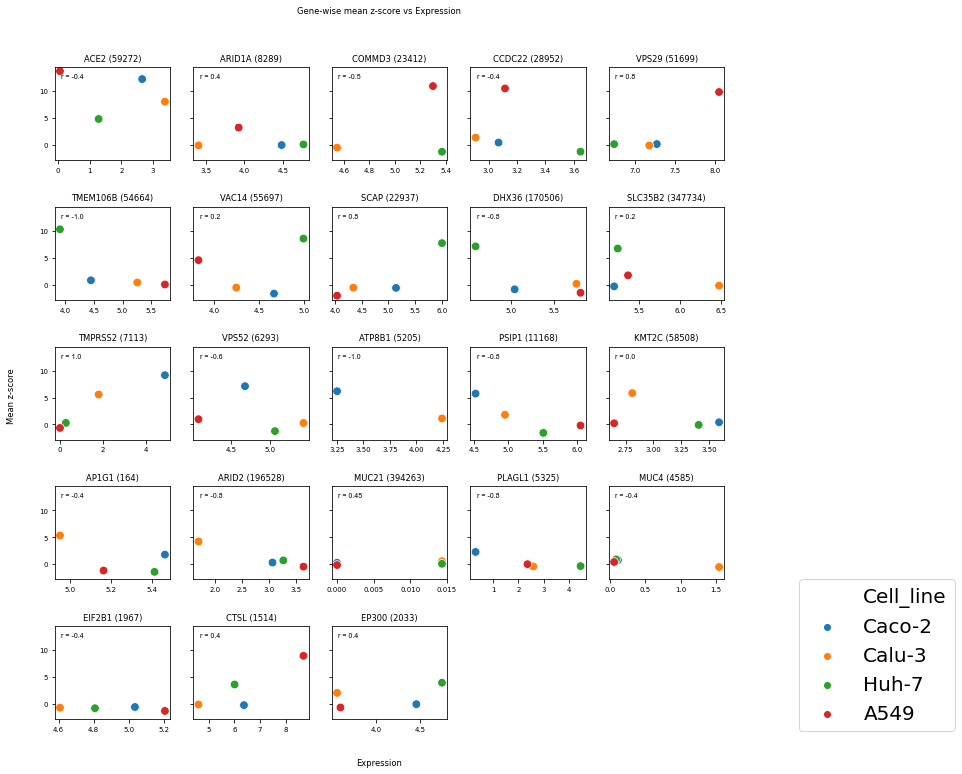

In [27]:
# Store separate data frames for each gene
gene_dict = {}

for gene in gene_col_list[1:]:
    gene_df = expression_z_df_full[expression_z_df_full['Gene'].eq(gene)].reset_index(drop=True)
    gene_dict[gene] = gene_df

# Plot z-score vs gene expression scatter plot for each gene
fig, axs = plt.subplots(5, 5, figsize = (12, 12), sharey= True)
row = 0
col = 0
gene_count = 0 
for key, df in gene_dict.items():
    ax = axs[row, col]
    if gene_count < len(gene_dict)-1:
        s = sns.scatterplot(data=df, x='Expression', y='z-score', hue='Cell_line', ax = ax, legend = False, s=75)
    else: 
        s = sns.scatterplot(data=df, x='Expression', y='z-score', hue='Cell_line', ax = ax, legend = 'full', s=75)
        ax.legend(prop={'size': 20}, bbox_to_anchor=(4.05, 1.5), loc=2, borderaxespad=0.)    
    
    gpp.add_correlation(data=df.dropna(), x='Expression', y='z-score', method='spearman', ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    # Set title as gene name
    ax.set_title(key)
    gene_count +=1
    if col < 4:
        col += 1
    else:
        if row < 4:
            col = 0
            row += 1

fig.delaxes(axs[4, 3])
fig.delaxes(axs[4, 4])

# plt.legend(prop={'size': 6}, bbox_to_anchor=(3.05, 1), loc=2, borderaxespad=0.)

plt.subplots_adjust(hspace=0.5)
fig.supxlabel('Expression', y=0.07)
fig.supylabel('Mean z-score', x = 0.07)
fig.suptitle('Gene-wise mean z-score vs Expression', y=0.95)
gpp.savefig('../../../Figures/Expressionvszscore.pdf', dpi=300)
fig.savefig('../../../Figures/Expressionvszscore.png', bbox_inches = 'tight')
        

## Cumulative distribution of top hits

### Vero E6: Wilen vs Goujon

In [30]:
# Read Vero E6 screen z-scores 
Vero_zscores_all = pd.read_excel('../../../Data/Processed/GEO_submission_v2/PrimaryScreens.xlsx', sheet_name='C. sabeus library')
control_cols = [col for col in Vero_zscores_all if 'control' in col]
# rank_cols = [col for col in Vero_zscores_all if 'Rank' in col]
cols_to_drop = control_cols #+ rank_cols
Vero_zscores = Vero_zscores_all.copy().drop(cols_to_drop, axis=1)
Vero_zscores


,Gene Symbol,residual_zscore_avg_Wilen,Rank_residual_zscore_avg_Wilen,residual_zscore_avg_Goujon_Vero,Rank_residual_zscore_avg_Goujon_Vero
0,SMARCA4,4.871878,1,6.936940,3
1,ACE2,4.858969,2,11.712143,1
2,DYRK1A,4.394741,3,4.439655,15
3,KDM6A,4.084949,4,6.508141,6
4,DPF2,3.896036,5,4.703072,13
...,...,...,...,...,...
20923,NONO,-4.339775,20924,-2.550392,20903
20924,BPTF,-4.351505,20925,-2.957462,20923
20925,TRIP12,-4.481919,20926,-2.017841,20820
20926,CABIN1,-5.366718,20927,-3.344440,20926


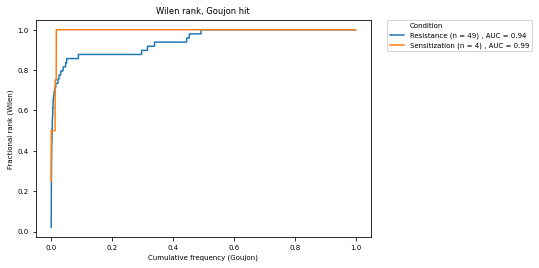

In [31]:
# Resistance: Assign 1 to genes with z-scores > 3 
Vero_zscores['Wilen_resistance_hit'] = (Vero_zscores['residual_zscore_avg_Wilen'] > 3).astype(int)
Vero_zscores['Goujon_resistance_hit'] = (Vero_zscores['residual_zscore_avg_Goujon_Vero'] > 3).astype(int)
Vero_zscores['Wilen_sensitization_hit'] = (Vero_zscores['residual_zscore_avg_Wilen'] < -3).astype(int)
Vero_zscores['Goujon_sensitization_hit'] = (Vero_zscores['residual_zscore_avg_Goujon_Vero'] < -3).astype(int)
   
# fig, ax = plt.subplots()
# s = sns.lineplot(data = cumulative_dist_df, x = 'Fractional_rank', y = 'Cumulative_freq', ci=None)

# Rank in reverse order for sensitization hits 
Vero_zscores_sensitization_Wilen_ranked = Vero_zscores.sort_values(by='Rank_residual_zscore_avg_Wilen', ascending=False)
Vero_zscores_sensitization_Wilen_ranked['Rank_residual_zscore_avg_Wilen_sen'] = Vero_zscores['residual_zscore_avg_Wilen'].rank(method='min', ascending=True)

Res_Wilen_rank, Res_Wilen_auc = cumulative_dist(df=Vero_zscores, annot_col = 'Gene Symbol', rank_col = 'Rank_residual_zscore_avg_Wilen', bool_col = 'Goujon_resistance_hit', condition = 'Resistance')
Sen_Wilen_rank, Sen_Wilen_auc = cumulative_dist(df=Vero_zscores_sensitization_Wilen_ranked, annot_col = 'Gene Symbol', rank_col = 'Rank_residual_zscore_avg_Wilen_sen', bool_col = 'Goujon_sensitization_hit', condition = 'Sensitization')

Wilen_rank = pd.concat([Res_Wilen_rank, Sen_Wilen_rank])

fig, ax = plt.subplots()
s = sns.lineplot(data = Wilen_rank, x = 'Fractional_rank', y = 'Cumulative_freq', ci=None, hue = 'Condition')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Wilen rank, Goujon hit')
plt.xlabel('Cumulative frequency (Goujon)')
plt.ylabel('Fractional rank (Wilen)')
fig.savefig('../../../Figures/Cumulative_dist_Wilen_rank_Goujon_hit.png', bbox_inches='tight')


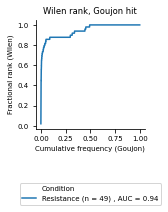

In [32]:
Res_Wilen_rank, Res_Wilen_auc = cumulative_dist(df=Vero_zscores, annot_col = 'Gene Symbol', rank_col = 'Rank_residual_zscore_avg_Wilen', bool_col = 'Goujon_resistance_hit', condition = 'Resistance')
# Sen_Wilen_rank, Sen_Wilen_auc = cumulative_dist(df=Vero_zscores_sensitization_Wilen_ranked, annot_col = 'Gene Symbol', rank_col = 'Rank_residual_zscore_avg_Wilen_sen', bool_col = 'Goujon_sensitization_hit', condition = 'Sensitization')

# Wilen_rank = pd.concat([Res_Wilen_rank, Sen_Wilen_rank])

plt.rcParams.update({'font.size': 7})

fig, ax = plt.subplots(figsize=(2, 2))
s = sns.lineplot(data = Res_Wilen_rank, x = 'Fractional_rank', y = 'Cumulative_freq', ci=None, hue = 'Condition')
ax.set_box_aspect(1)
plt.legend(bbox_to_anchor=(0.5, -0.7), loc='lower center', borderaxespad=0.)
plt.title('Wilen rank, Goujon hit')
plt.xlabel('Cumulative frequency (Goujon)')
plt.ylabel('Fractional rank (Wilen)')
sns.despine()
fig.savefig('../../../Figures/Cumulative_dist_Wilen_rank_Goujon_resistance_hit.png', dpi=300, bbox_inches='tight')
gpp.savefig('../../../Figures/Cumulative_dist_Wilen_rank_Goujon_resistance_hit.pdf', dpi=300)


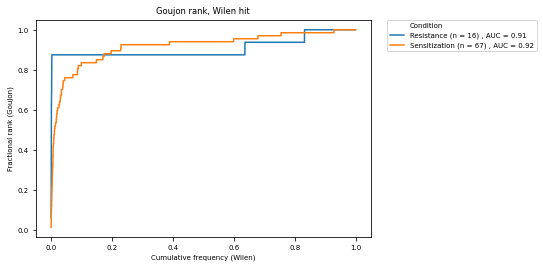

In [33]:
Vero_zscores_Goujon_ranked = Vero_zscores.sort_values('Rank_residual_zscore_avg_Goujon_Vero')

# Rank in reverse order for sensitization hits 
Vero_zscores_sensitization_Goujon_ranked = Vero_zscores.sort_values(by='Rank_residual_zscore_avg_Goujon_Vero', ascending=False)
Vero_zscores_sensitization_Goujon_ranked['Rank_residual_zscore_avg_Goujon_sen'] = Vero_zscores['residual_zscore_avg_Goujon_Vero'].rank(method='min', ascending=True)

# Vero_zscores_Goujon_ranked_rev = Vero_zscores.sort_values('Rank_residual_zscore_avg_Goujon_Vero', ascending=False)
Res_Goujon_rank, Res_Goujon_Vero_auc = cumulative_dist(df=Vero_zscores_Goujon_ranked, annot_col = 'Gene Symbol', rank_col = 'Rank_residual_zscore_avg_Goujon_Vero', bool_col = 'Wilen_resistance_hit', condition = 'Resistance')

Sen_Goujon_rank, Sen_Goujon_auc = cumulative_dist(df=Vero_zscores_sensitization_Goujon_ranked, annot_col = 'Gene Symbol', rank_col = 'Rank_residual_zscore_avg_Goujon_sen', bool_col = 'Wilen_sensitization_hit', condition = 'Sensitization')

Goujon_rank = pd.concat([Res_Goujon_rank, Sen_Goujon_rank])

fig, ax = plt.subplots()
s = sns.lineplot(data = Goujon_rank, x = 'Fractional_rank', y = 'Cumulative_freq', ci=None, hue = 'Condition')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Goujon rank, Wilen hit')
plt.xlabel('Cumulative frequency (Wilen)')
plt.ylabel('Fractional rank (Goujon)')
fig.savefig('../../../Figures/Cumulative_dist_Goujon_rank_Wilen_hit.png', bbox_inches='tight')

  

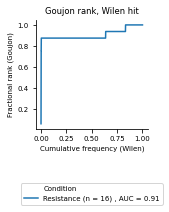

In [34]:
fig, ax = plt.subplots(figsize=(2,2))
s = sns.lineplot(data = Res_Goujon_rank, x = 'Fractional_rank', y = 'Cumulative_freq', ci=None, hue = 'Condition')
plt.legend(bbox_to_anchor=(0.5, -0.7), loc='lower center', borderaxespad=0.)
plt.title('Goujon rank, Wilen hit')
plt.xlabel('Cumulative frequency (Wilen)')
plt.ylabel('Fractional rank (Goujon)')
sns.despine()
fig.savefig('../../../Figures/Cumulative_dist_Goujon_rank_Wilen_resistance_hit.png', dpi=300, bbox_inches='tight')
gpp.savefig('../../../Figures/Cumulative_dist_Goujon_rank_Wilen_resistance_hit.pdf', dpi=300)
  

In [35]:
Vero_auc_df = pd.DataFrame()
Vero_auc_df.loc[0, 'Condition'] = 'Goujon rank, Wilen hit'
Vero_auc_df.loc[0, 'AUC'] = Res_Goujon_Vero_auc
Vero_auc_df.loc[1, 'Condition'] = 'Wilen rank, Goujon hit'
Vero_auc_df.loc[1, 'AUC'] = Res_Wilen_auc
# Vero_auc_df.loc[0, 'Wilen rank, Goujon hit'] = Res_Goujon_Vero_auc
Vero_auc_df
# sns.barplot(data=Vero_auc_df, x='Condition', y='AUC')

,Condition,AUC
0,"Goujon rank, Wilen hit",0.907628
1,"Wilen rank, Goujon hit",0.943811


### Calu-3: Hsu vs Goujon

#### KO

In [45]:
# Read Calu-3 screen z-scores 
Calu3_KO_zscores_Goujon = pd.read_excel('../../../Data/Processed/GEO_submission_v2/PrimaryScreens.xlsx', sheet_name='Gattinara')
Brunello_zscores = pd.read_excel('../../../Data/Processed/GEO_submission_v2/PrimaryScreens.xlsx', sheet_name='Brunello')
Hsu_cols = ['Gene Symbol'] + [col for col in Brunello_zscores.columns if 'Hsu' in col]
Calu3_KO_zscores_Hsu = Brunello_zscores[Hsu_cols].copy()

Calu3_KO_zscores_all = pd.merge(Calu3_KO_zscores_Goujon, Calu3_KO_zscores_Hsu, on = 'Gene Symbol', how = 'outer')

control_cols = [col for col in Calu3_KO_zscores_all if 'control' in col]
rank_cols = [col for col in Calu3_KO_zscores_all if 'Rank' in col]

cols_to_drop = control_cols + rank_cols
Calu3_KO_zscores = Calu3_KO_zscores_all.copy().drop(cols_to_drop, axis=1)
Calu3_KO_zscores


,Gene Symbol,residual_zscore_avg_Goujon_Calu3_Gat,residual_zscore_avg_Hsu_Calu3_KO
0,ACE2,8.050874,6.686465
1,KMT2C,5.831425,3.685848
2,TMPRSS2,5.569093,3.489821
3,AP1G1,5.347534,7.455134
4,ARID2,4.232285,2.640331
...,...,...,...
22087,LOC107985304,NaN,NaN
22088,NBPF22P,NaN,NaN
22089,LINC02870,NaN,NaN
22090,44531,NaN,0.546166


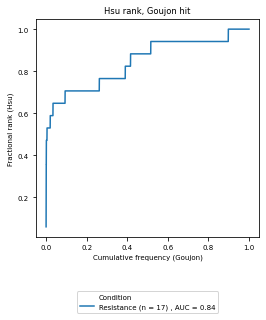

In [46]:
# Resistance: Assign 1 to genes with z-scores > 3 or < -3
Calu3_KO_zscores['Hsu_resistance_hit'] = (Calu3_KO_zscores['residual_zscore_avg_Hsu_Calu3_KO'] > 3).astype(int)
Calu3_KO_zscores['Goujon_resistance_hit'] = (Calu3_KO_zscores['residual_zscore_avg_Goujon_Calu3_Gat'] > 3).astype(int)
Calu3_KO_zscores['Hsu_sensitization_hit'] = (Calu3_KO_zscores['residual_zscore_avg_Hsu_Calu3_KO'] < -3).astype(int)
Calu3_KO_zscores['Goujon_sensitization_hit'] = (Calu3_KO_zscores['residual_zscore_avg_Goujon_Calu3_Gat'] < -3).astype(int)

# Reformat data frame so ranked in descending order of z-score in Hsu screen 
Calu3_KO_zscores_Hsu_ranked = Calu3_KO_zscores.copy().dropna()
Calu3_KO_zscores_Hsu_ranked['Rank_residual_zscore_avg_Hsu_Calu3_KO'] = Calu3_KO_zscores['residual_zscore_avg_Hsu_Calu3_KO'].copy().rank(method='min', ascending=False)
Calu3_KO_zscores_Hsu_ranked = Calu3_KO_zscores_Hsu_ranked.copy().sort_values(by='Rank_residual_zscore_avg_Hsu_Calu3_KO').reset_index(drop=True)

Calu3_KO_zscores_Hsu_ranked#.sort_values('Rank_residual_zscore_avg_Hsu_Calu3_KO')

# No Goujon sensitization hits 
# Rank in reverse order for sensitization hits 
# Calu3_KO_zscores_sensitization_Hsu_ranked = Calu3_KO_zscores.sort_values(by='Rank_residual_zscore_avg_Hsu_Calu3_KO', ascending=False)
# Calu3_KO_zscores_sensitization_Hsu_ranked['Rank_residual_zscore_avg_Hsu_Calu3_KO_sen'] = Calu3_KO_zscores['residual_zscore_avg_Hsu_Calu3_KO'].rank(method='min', ascending=True)

Res_Hsu_rank, Res_Hsu_auc = cumulative_dist(df=Calu3_KO_zscores_Hsu_ranked, annot_col = 'Gene Symbol', rank_col = 'Rank_residual_zscore_avg_Hsu_Calu3_KO', bool_col = 'Goujon_resistance_hit', condition = 'Resistance')
# Sen_Hsu_rank, Sen_Hsu_auc = cumulative_dist(df=Calu3_KO_zscores_sensitization_Hsu_ranked, annot_col = 'Gene Symbol', rank_col = 'Rank_residual_zscore_avg_Hsu_Calu3_KO_sen', bool_col = 'Goujon_sensitization_hit', condition = 'Sensitization')
Res_Hsu_rank
# Hsu_rank = pd.concat([Res_Hsu_rank, Sen_Hsu_rank])

fig, ax = plt.subplots(figsize=(4,4))
s = sns.lineplot(data = Res_Hsu_rank, x = 'Fractional_rank', y = 'Cumulative_freq', ci=None, hue = 'Condition')
plt.legend(bbox_to_anchor=(0.5, -0.35), loc='lower center', borderaxespad=0.)
plt.title('Hsu rank, Goujon hit')
plt.xlabel('Cumulative frequency (Goujon)')
plt.ylabel('Fractional rank (Hsu)')
fig.savefig('../../../Figures/Cumulative_dist_Hsu_KO_rank_Goujon_hit.png', dpi=300, bbox_inches='tight')


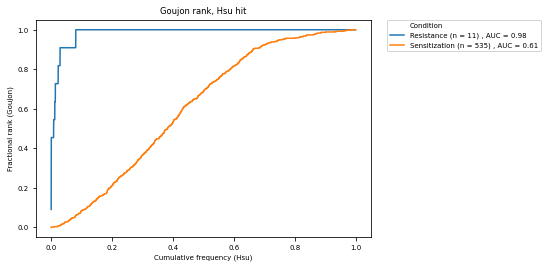

In [47]:
# Reformat data frame so ranked in descending order of z-score in Goujon screen 
Calu3_KO_zscores_Goujon_ranked = Calu3_KO_zscores.copy().dropna()
Calu3_KO_zscores_Goujon_ranked['Rank_residual_zscore_avg_Goujon_Calu3_Gat'] = Calu3_KO_zscores['residual_zscore_avg_Goujon_Calu3_Gat'].copy().rank(method='min', ascending=False)
Calu3_KO_zscores_Goujon_ranked = Calu3_KO_zscores_Goujon_ranked.copy().sort_values(by='Rank_residual_zscore_avg_Goujon_Calu3_Gat').reset_index(drop=True)

Calu3_KO_zscores_Goujon_ranked#.sort_values('Rank_residual_zscore_avg_Goujon_Calu3_Gat')

# Rank in reverse order for sensitization hits 
Calu3_KO_zscores_sensitization_Goujon_ranked = Calu3_KO_zscores_Goujon_ranked.sort_values(by='Rank_residual_zscore_avg_Goujon_Calu3_Gat', ascending=False)
Calu3_KO_zscores_sensitization_Goujon_ranked['Rank_residual_zscore_avg_Goujon_Calu3_Gat_sen'] = Calu3_KO_zscores_Goujon_ranked['residual_zscore_avg_Goujon_Calu3_Gat'].rank(method='min', ascending=True)

Res_Goujon_Calu3_rank, Res_Goujon_Calu3_auc = cumulative_dist(df=Calu3_KO_zscores_Goujon_ranked, annot_col = 'Gene Symbol', rank_col = 'Rank_residual_zscore_avg_Goujon_Calu3_Gat', bool_col = 'Hsu_resistance_hit', condition = 'Resistance')
Sen_Goujon_Calu3_rank, Sen_Goujon_Calu3_auc = cumulative_dist(df=Calu3_KO_zscores_sensitization_Goujon_ranked, annot_col = 'Gene Symbol', rank_col = 'Rank_residual_zscore_avg_Goujon_Calu3_Gat_sen', bool_col = 'Hsu_sensitization_hit', condition = 'Sensitization')
# Res_Hsu_rank
Goujon_Calu3_rank = pd.concat([Res_Goujon_Calu3_rank, Sen_Goujon_Calu3_rank])

fig, ax = plt.subplots()
s = sns.lineplot(data = Goujon_Calu3_rank, x = 'Fractional_rank', y = 'Cumulative_freq', ci=None, hue = 'Condition')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Goujon rank, Hsu hit')
plt.xlabel('Cumulative frequency (Hsu)')
plt.ylabel('Fractional rank (Goujon)')
fig.savefig('../../../Figures/Cumulative_dist_Goujon_KO_rank_Hsu_hit.png', bbox_inches='tight')


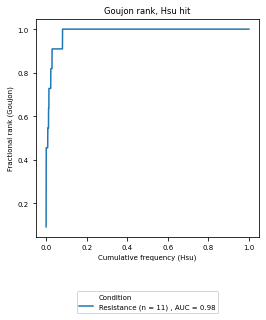

In [48]:
fig, ax = plt.subplots(figsize=(4,4))
s = sns.lineplot(data = Res_Goujon_Calu3_rank, x = 'Fractional_rank', y = 'Cumulative_freq', ci=None, hue = 'Condition')
plt.legend(bbox_to_anchor=(0.5, -0.35), loc='lower center', borderaxespad=0.)
plt.title('Goujon rank, Hsu hit')
plt.xlabel('Cumulative frequency (Hsu)')
plt.ylabel('Fractional rank (Goujon)')
fig.savefig('../../../Figures/Cumulative_dist_Goujon_KO_rank_Hsu_resistance_hit.png', dpi=300, bbox_inches='tight')


#### Activation

In [40]:
# Read Calu-3 activation screen z-scores 
Calu3_Act_zscores_all = pd.read_excel('../../../Data/Processed/GEO_submission_v2/PrimaryScreens.xlsx', sheet_name='Calabrese')
Calu3_Act_zscores_all
control_cols = [col for col in Calu3_Act_zscores_all if 'control' in col]
cols_to_drop = control_cols #+ rank_cols
Calu3_Act_zscores = Calu3_Act_zscores_all.copy().drop(cols_to_drop, axis=1)
Calu3_Act_zscores


,Gene Symbol,residual_zscore_avg_Goujon_Calu3_Cal,Rank_residual_zscore_avg_Goujon_Calu3_Cal,residual_zscore_avg_Hsu_Calu3_Cal,Rank_residual_zscore_avg_Hsu_Calu3_Cal
0,ACE2,-5.882191,1.0,-10.243243,1.0
1,SLC6A14,-4.723786,2.0,-3.140675,26.0
2,FOXL2NB,-3.791697,3.0,-2.708302,46.0
3,FOXL2,-3.334617,4.0,-0.911948,1207.0
4,TP73,-3.171661,5.0,-3.618013,12.0
...,...,...,...,...,...
21896,HIST2H4B,NaN,NaN,1.647003,18837.0
21897,LSM1,NaN,NaN,1.717758,18852.0
21898,ARHGAP21,NaN,NaN,1.786080,18872.0
21899,SKOR1,NaN,NaN,2.100193,18907.0


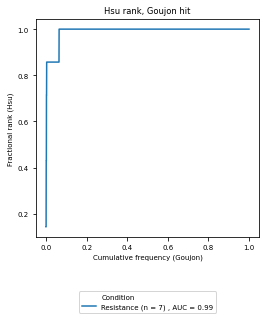

In [41]:
# Resistance: Assign 1 to genes with z-scores > 3 
Calu3_Act_zscores['Hsu_resistance_hit'] = (Calu3_Act_zscores['residual_zscore_avg_Hsu_Calu3_Cal'] < -3).astype(int)
Calu3_Act_zscores['Goujon_resistance_hit'] = (Calu3_Act_zscores['residual_zscore_avg_Goujon_Calu3_Cal'] < -3).astype(int)
Calu3_Act_zscores['Hsu_sensitization_hit'] = (Calu3_Act_zscores['residual_zscore_avg_Hsu_Calu3_Cal'] > 3).astype(int)
Calu3_Act_zscores['Goujon_sensitization_hit'] = (Calu3_Act_zscores['residual_zscore_avg_Goujon_Calu3_Cal'] > 3).astype(int)
   
Calu3_Act_zscores_Hsu_ranked = Calu3_Act_zscores.copy().dropna().sort_values('Rank_residual_zscore_avg_Hsu_Calu3_Cal').reset_index(drop=True)
# fig, ax = plt.subplots()
# s = sns.lineplot(data = cumulative_dist_df, x = 'Fractional_rank', y = 'Cumulative_freq', ci=None)

# Rank in reverse order for sensitization hits 
# Calu3_Act_zscores_sensitization_Hsu_ranked = Calu3_Act_zscores_Hsu_ranked.sort_values(by='Rank_residual_zscore_avg_Hsu_Calu3_Cal', ascending=False)
# Calu3_Act_zscores_sensitization_Hsu_ranked['Rank_residual_zscore_avg_Hsu_Calu3_Cal_sen'] = Calu3_Act_zscores_Hsu_ranked['residual_zscore_avg_Hsu_Calu3_Cal'].rank(method='min', ascending=True)

Res_Hsu_Act_rank, Res_Hsu_Act_auc = cumulative_dist(df=Calu3_Act_zscores_Hsu_ranked, annot_col = 'Gene Symbol', rank_col = 'Rank_residual_zscore_avg_Hsu_Calu3_Cal', bool_col = 'Goujon_resistance_hit', condition = 'Resistance')
# Sen_Hsu_rank, Sen_Hsu_auc = cumulative_dist(df=Calu3_Act_zscores_sensitization_Hsu_ranked, annot_col = 'Gene Symbol', rank_col = 'Rank_residual_zscore_avg_Hsu_Calu3_Cal_sen', bool_col = 'Goujon_sensitization_hit', condition = 'Sensitization')

# Hsu_Act_rank = pd.concat([Res_Hsu_rank, Sen_Hsu_rank])

fig, ax = plt.subplots(figsize=(4,4))
s = sns.lineplot(data = Res_Hsu_Act_rank, x = 'Fractional_rank', y = 'Cumulative_freq', ci=None, hue = 'Condition')
plt.legend(bbox_to_anchor=(0.5, -0.35), loc='lower center', borderaxespad=0.)
plt.title('Hsu rank, Goujon hit')
plt.xlabel('Cumulative frequency (Goujon)')
plt.ylabel('Fractional rank (Hsu)')
fig.savefig('../../../Figures/Cumulative_dist_Hsu_Act_rank_Goujon_hit.png', dpi=300, bbox_inches='tight')


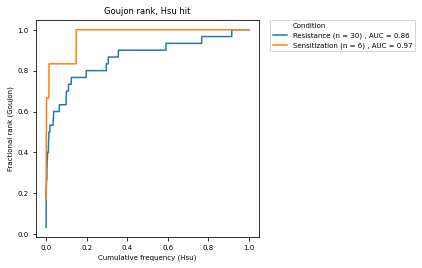

In [42]:
# Resistance: Assign 1 to genes with z-scores > 3 
Calu3_Act_zscores_Goujon_ranked = Calu3_Act_zscores.copy().dropna().sort_values('Rank_residual_zscore_avg_Goujon_Calu3_Cal').reset_index(drop=True)
# fig, ax = plt.subplots()
# s = sns.lineplot(data = cumulative_dist_df, x = 'Fractional_rank', y = 'Cumulative_freq', ci=None)

# Rank in reverse order for sensitization hits 
Calu3_Act_zscores_sensitization_Goujon_ranked = Calu3_Act_zscores_Goujon_ranked.sort_values(by='Rank_residual_zscore_avg_Goujon_Calu3_Cal', ascending=False).reset_index(drop=True)
Calu3_Act_zscores_sensitization_Goujon_ranked['Rank_residual_zscore_avg_Goujon_Calu3_Cal_sen'] = Calu3_Act_zscores_Goujon_ranked['residual_zscore_avg_Goujon_Calu3_Cal'].rank(method='min', ascending=True)
# Calu3_Act_zscores_sensitization_Goujon_rankedreset_index(drop=True)

Res_Goujon_Act_rank, Res_Goujon_Act_auc = cumulative_dist(df=Calu3_Act_zscores_Goujon_ranked, annot_col = 'Gene Symbol', rank_col = 'Rank_residual_zscore_avg_Goujon_Calu3_Cal', bool_col = 'Hsu_resistance_hit', condition = 'Resistance')
Sen_Goujon_Act_rank, Sen_Goujon_Act_auc = cumulative_dist(df=Calu3_Act_zscores_sensitization_Goujon_ranked, annot_col = 'Gene Symbol', rank_col = 'Rank_residual_zscore_avg_Goujon_Calu3_Cal_sen', bool_col = 'Hsu_sensitization_hit', condition = 'Sensitization')

Goujon_Act_rank = pd.concat([Res_Goujon_Act_rank, Sen_Goujon_Act_rank])

fig, ax = plt.subplots(figsize=(4,4))
s = sns.lineplot(data = Goujon_Act_rank, x = 'Fractional_rank', y = 'Cumulative_freq', ci=None, hue = 'Condition')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Goujon rank, Hsu hit')
plt.xlabel('Cumulative frequency (Hsu)')
plt.ylabel('Fractional rank (Goujon)')
fig.savefig('../../../Figures/Cumulative_dist_Goujon_Act_rank_Hsu_hit.png', bbox_inches='tight')


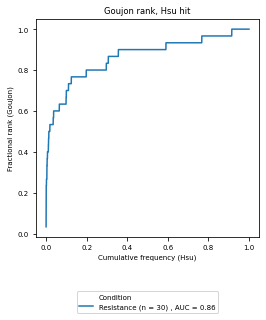

In [43]:
fig, ax = plt.subplots(figsize=(4,4))
s = sns.lineplot(data = Res_Goujon_Act_rank, x = 'Fractional_rank', y = 'Cumulative_freq', ci=None, hue = 'Condition')
plt.legend(bbox_to_anchor=(0.5, -0.35), loc='lower center', borderaxespad=0.)
plt.title('Goujon rank, Hsu hit')
plt.xlabel('Cumulative frequency (Hsu)')
plt.ylabel('Fractional rank (Goujon)')
fig.savefig('../../../Figures/Cumulative_dist_Goujon_Act_rank_Hsu_resistance_hit.png', dpi=300, bbox_inches='tight')
